In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Holt Winter Model

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true,y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100  

In [2]:
data= pd.read_csv("cleaned_data_csv.csv")

In [3]:
def create_df(data,location):
    #Selecting the 7 key columns for country in dataset
    data=data[data['Location']==location].copy()
    data=data[['Date','Total_Cases','New_Cases',
         'Total_deaths','New_deaths',
         "people vaccinated per hundred", 'people_fully_vaccinated_per_hundred',
          'new cases per million']].copy()
    #Convert to datetime
    #data2.date = pd.to_datetime(data2['Date'])
    data['Date'] = pd.DatetimeIndex(data['Date'])
    return data

In [4]:
asia_1=create_df(data,'Japan')

In [5]:
asia_1=asia_1.loc[:,['Date',"new cases per million"]]
asia_1=asia_1.set_index('Date')

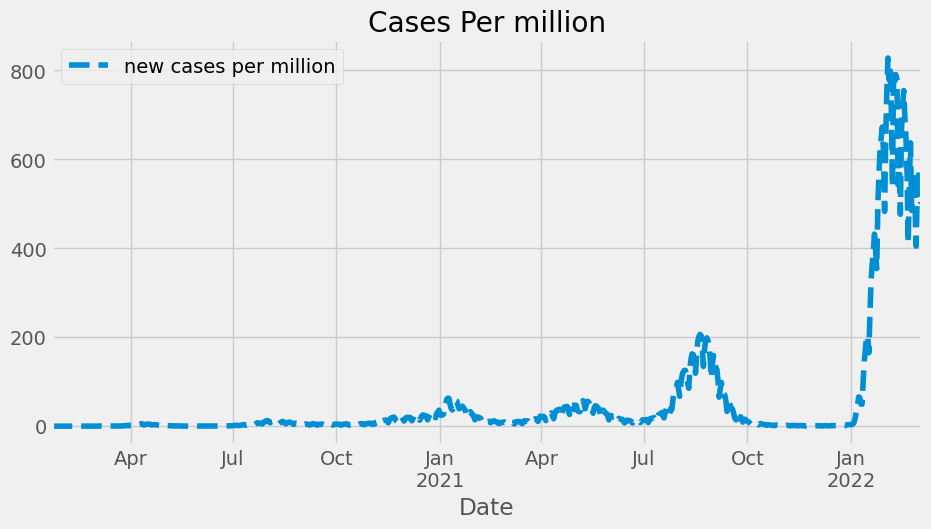

In [6]:
color_pal = sns.color_palette()
asia_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

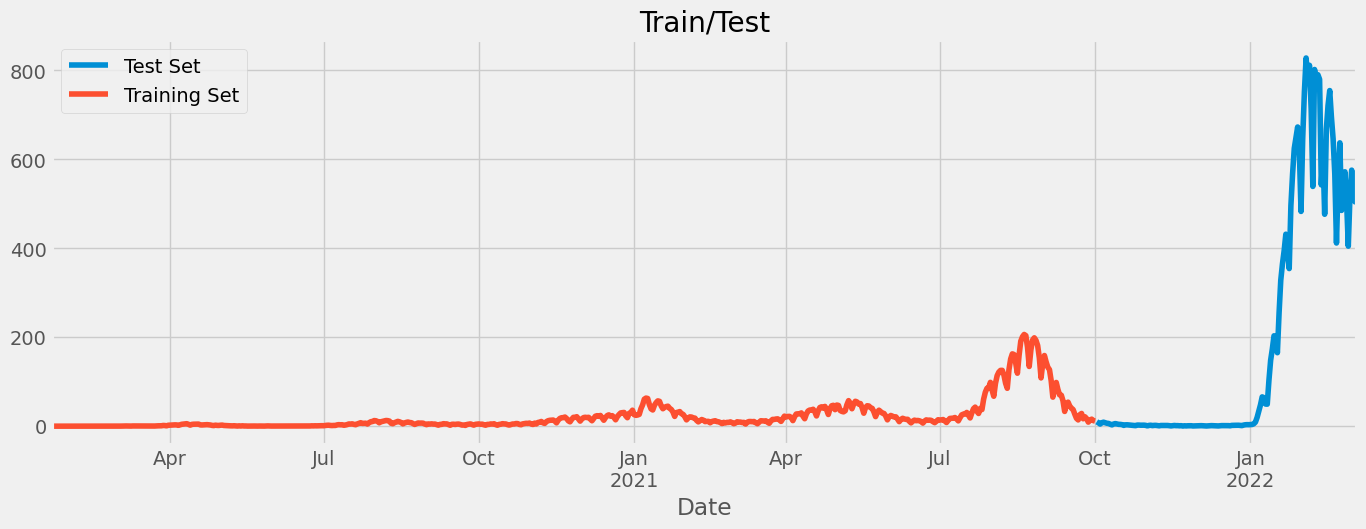

In [7]:
split_date='01-oct-2021'

asia_train1 = asia_1.loc[asia_1.index <=split_date].copy()
asia_test1 = asia_1.loc[asia_1.index >split_date].copy()

asia_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(asia_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [8]:
# Rename columns as required by Prophet
dataasia_1 = asia_train1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [9]:
# Rename columns as required by Prophet
datetest_asia1 = asia_test1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [10]:
# Define function to evaluate model performance
def evaluate_model(predictions_asia1, actual_asia1):
    mse_asia1 = mean_squared_error(actual_asia1, predictions_asia1)
    rmse_asia1 = np.sqrt(mse_asia1)
    mape_asia1 = np.mean(np.abs((actual_asia1 - predictions_asia1) / actual_asia1)) * 100
    return mse_asia1, rmse_asia1, mape_asia1

In [11]:
# Initialize and fit the Prophet model on train data
model_asia1 = Prophet()
model_asia1.fit(dataasia_1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/ssptydvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/y3b5ivvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16994', 'data', 'file=/tmp/tmpl3hu94pc/ssptydvp.json', 'init=/tmp/tmpl3hu94pc/y3b5ivvc.json', 'output', 'file=/tmp/tmpl3hu94pc/prophet_modelt76vdaj5/prophet_model-20230414154550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
n_days_asia1 = 365

In [13]:
future_dates_asia1 = model_asia1.make_future_dataframe(periods=n_days_asia1)

In [14]:
# Use the trained model to make predictions for the next n_days
forecast_asia1 = model_asia1.predict(future_dates_asia1)
# Access the 'yhat_lower' column
forecast_asia1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-2.577617,-35.395875,29.879290
1,2020-01-23,-1.809708,-33.546166,28.908118
2,2020-01-24,-2.644798,-35.194582,30.017707
3,2020-01-25,-1.611123,-33.925337,33.295828
4,2020-01-26,-5.508310,-38.558397,27.800224
...,...,...,...,...
979,2022-09-27,216.595122,180.674759,254.989910
980,2022-09-28,220.725848,184.587036,257.981673
981,2022-09-29,221.802001,186.717819,261.751467
982,2022-09-30,221.275157,183.744531,259.087219


In [15]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_asia1, forecast_asia1)
fig.show()

In [16]:
# Evaluate model performance on test data
test_predictions_asia1 = model_asia1.predict(datetest_asia1[['ds']])
test_predictions_asia1 = test_predictions_asia1[['ds', 'yhat']]
test_predictions_asia1 = test_predictions_asia1.merge(datetest_asia1, on='ds')
test_predictions_asia1 = test_predictions_asia1[['yhat', 'y']]
mse_asia1, rmse_asia1, mape_asia1 = evaluate_model(test_predictions_asia1['yhat'], test_predictions_asia1['y'])

In [17]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_asia1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_asia1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_asia1:.2f}%')


Mean Squared Error (MSE): 73049.65
Root Mean Squared Error (RMSE): 270.28
Mean Absolute Percentage Error (MAPE): 4683.00%


In [18]:
asia_2=create_df(data,'Singapore')

In [19]:
asia_2=asia_2.loc[:,['Date',"new cases per million"]]
asia_2=asia_2.set_index('Date')

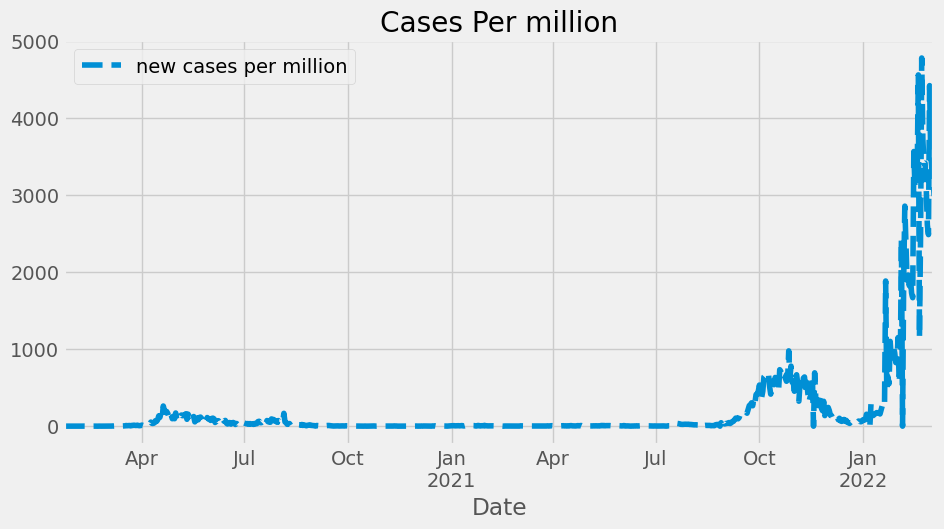

In [20]:
color_pal = sns.color_palette()
asia_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

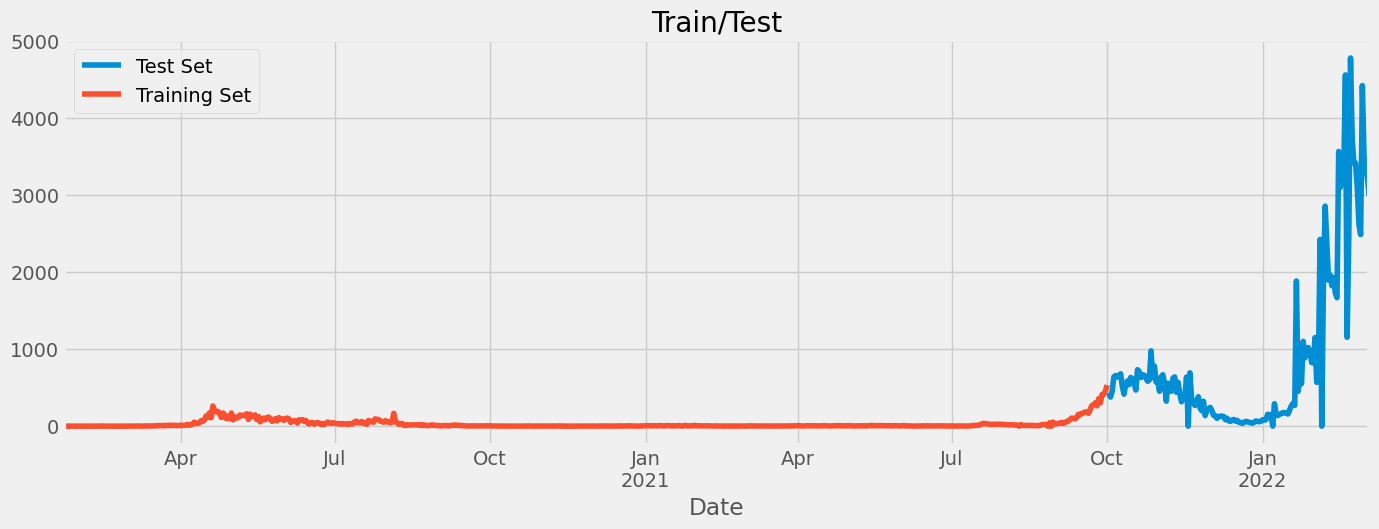

In [21]:
split_date='01-oct-2021'

asia_train2 = asia_2.loc[asia_2.index <=split_date].copy()
asia_test2 = asia_2.loc[asia_2.index >split_date].copy()

asia_test2 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(asia_train2.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [22]:
# Rename columns as required by Prophet
dataasia_2 = asia_train2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [23]:
# Rename columns as required by Prophet
datetest_asia2 = asia_test2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [24]:
# Define function to evaluate model performance
def evaluate_model(predictions_asia2, actual_asia2):
    mse_asia2 = mean_squared_error(actual_asia2, predictions_asia2)
    rmse_asia2 = np.sqrt(mse_asia2)
    mape_asia2 = np.mean(np.abs((actual_asia2 - predictions_asia2) / actual_asia2)) * 100
    return mse_asia2, rmse_asia2, mape_asia2

In [25]:
# Initialize and fit the Prophet model on train data
model_asia2 = Prophet()
model_asia2.fit(dataasia_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/5o20aosg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/zz06lsn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48306', 'data', 'file=/tmp/tmpl3hu94pc/5o20aosg.json', 'init=/tmp/tmpl3hu94pc/zz06lsn7.json', 'output', 'file=/tmp/tmpl3hu94pc/prophet_model5w879g6a/prophet_model-20230414154552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [26]:
n_days_asia2 = 365

In [27]:
future_dates_asia2 = model_asia2.make_future_dataframe(periods=n_days_asia2)

In [28]:
# Use the trained model to make predictions for the next n_days
forecast_asia2 = model_asia2.predict(future_dates_asia2)
# Access the 'yhat_lower' column
forecast_asia2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-23,-8.483464,-64.427455,42.080865
1,2020-01-24,-5.639509,-63.741559,49.731414
2,2020-01-25,-11.287094,-67.580229,39.439225
3,2020-01-26,-8.996222,-60.208012,47.332515
4,2020-01-27,-9.616719,-65.912549,47.564668
...,...,...,...,...
978,2022-09-27,561.357499,385.978327,738.088020
979,2022-09-28,566.233834,382.679715,724.086276
980,2022-09-29,566.498008,390.754146,735.400111
981,2022-09-30,569.661276,393.167720,742.367605


In [29]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_asia2, forecast_asia2)
fig.show()

In [30]:
# Evaluate model performance on test data
test_predictions_asia2 = model_asia2.predict(datetest_asia2[['ds']])
test_predictions_asia2 = test_predictions_asia2[['ds', 'yhat']]
test_predictions_asia2 = test_predictions_asia2.merge(datetest_asia2, on='ds')
test_predictions_asia2 = test_predictions_asia2[['yhat', 'y']]
mse_asia2, rmse_asia2, mape_asia2 = evaluate_model(test_predictions_asia2['yhat'], test_predictions_asia2['y'])

In [31]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_asia2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_asia2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_asia2:.2f}%')

Mean Squared Error (MSE): 1485306.32
Root Mean Squared Error (RMSE): 1218.73
Mean Absolute Percentage Error (MAPE): inf%


In [32]:
#AFRICA

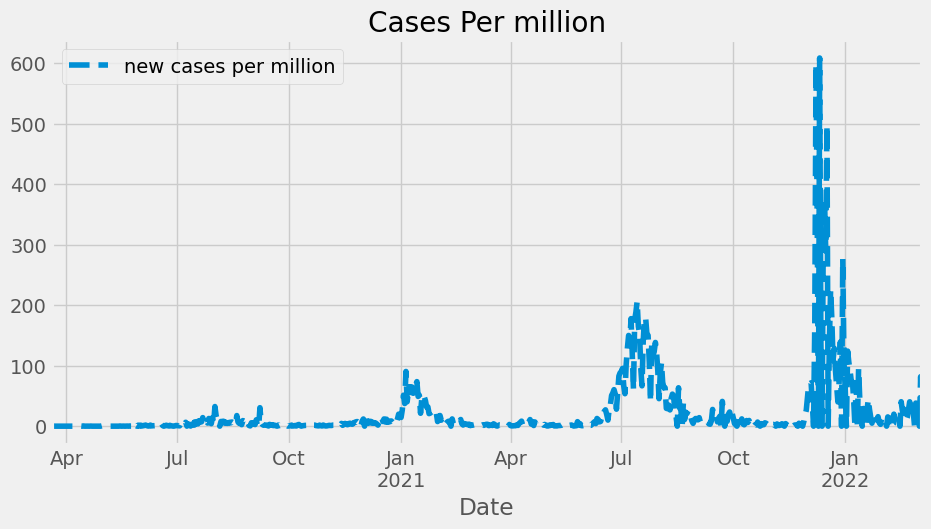

In [33]:
africa_1=create_df(data,'Zimbabwe')

africa_1=africa_1.loc[:,['Date',"new cases per million"]]
africa_1=africa_1.set_index('Date')

color_pal = sns.color_palette()
africa_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

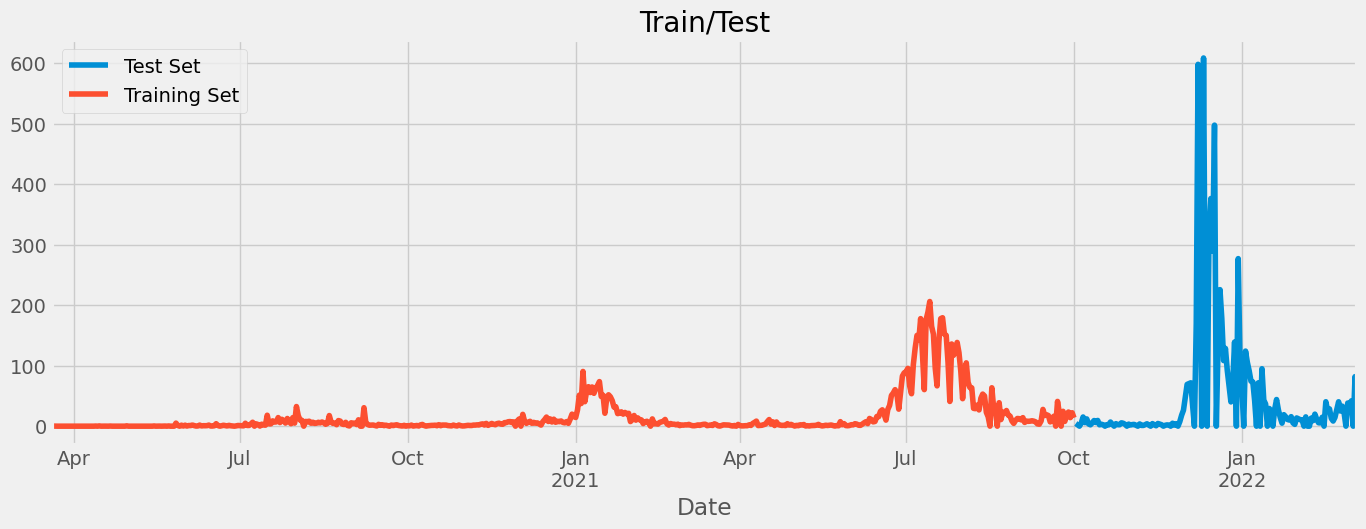

In [34]:
split_date='01-oct-2021'

africa_train1 = africa_1.loc[africa_1.index <=split_date].copy()
africa_test1 = africa_1.loc[africa_1.index >split_date].copy()

africa_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(africa_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()


In [35]:
# Rename columns as required by Prophet
dataafrica_1 = africa_train1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [36]:
# Rename columns as required by Prophet
datetest_africa1 = africa_test1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [37]:
# Define function to evaluate model performance
def evaluate_model(predictions_africa1, actual_africa1):
    mse_africa1 = mean_squared_error(actual_africa1, predictions_africa1)
    rmse_africa1 = np.sqrt(mse_africa1)
    mape_africa1 = np.mean(np.abs((actual_africa1 - predictions_africa1) / actual_africa1)) * 100
    return mse_africa1, rmse_africa1, mape_africa1

In [38]:
# Initialize and fit the Prophet model on train data
model_africa1 = Prophet()
model_africa1.fit(dataafrica_1)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/sj57lcn7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/zt7hapii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77049', 'data', 'file=/tmp/tmpl3hu94pc/sj57lcn7.json', 'init=/tmp/tmpl3hu94pc/zt7hapii.json', 'output', 'file=/tmp/tmpl3hu94pc/prophet_modelqb0n8g6p/prophet_model-20230414154554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
n_days_africa1 = 365

In [40]:
future_dates_africa1 = model_africa1.make_future_dataframe(periods=n_days_africa1)

In [41]:
# Use the trained model to make predictions for the next n_days
forecast_africa1 = model_africa1.predict(future_dates_africa1)
# Access the 'yhat_lower' column
forecast_africa1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-20,-1.602228,-39.478036,32.284509
1,2020-03-21,-4.769725,-39.061081,32.109168
2,2020-03-22,-9.502903,-45.729157,27.200392
3,2020-03-23,-3.036949,-40.198463,35.664593
4,2020-03-24,0.106167,-34.280036,38.612249
...,...,...,...,...
921,2022-09-27,104.917388,67.521851,143.572296
922,2022-09-28,105.022937,67.116668,142.629469
923,2022-09-29,104.687367,67.467401,140.896409
924,2022-09-30,103.865601,68.119256,142.817273


In [42]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_africa1, forecast_africa1)
fig.show()

In [43]:
# Evaluate model performance on test data
test_predictions_africa1 = model_africa1.predict(datetest_africa1[['ds']])
test_predictions_africa1 = test_predictions_africa1[['ds', 'yhat']]
test_predictions_africa1 = test_predictions_africa1.merge(datetest_africa1, on='ds')
test_predictions_africa1 = test_predictions_africa1[['yhat', 'y']]
mse_africa1, rmse_africa1, mape_africa1 = evaluate_model(test_predictions_africa1['yhat'], test_predictions_africa1['y'])

In [44]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_africa1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_africa1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_africa1:.2f}%')

Mean Squared Error (MSE): 9828.75
Root Mean Squared Error (RMSE): 99.14
Mean Absolute Percentage Error (MAPE): inf%


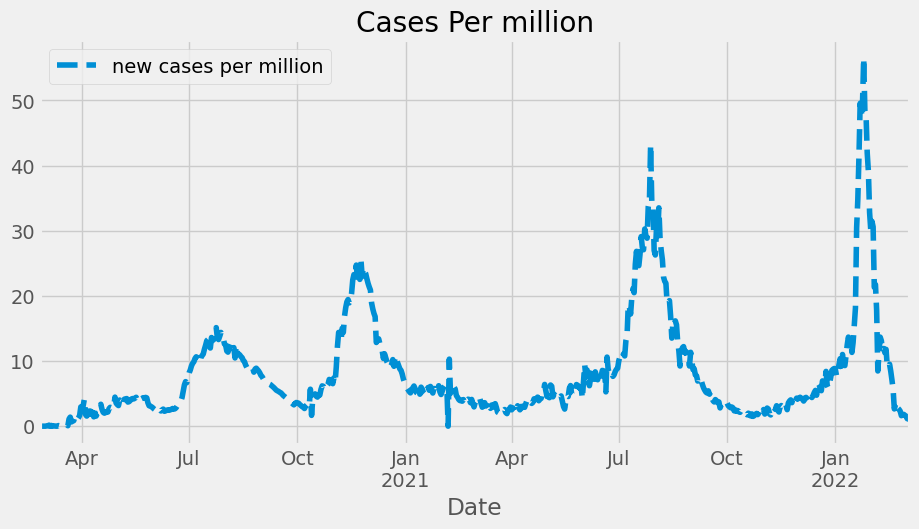

In [45]:
africa_2=create_df(data,'Algeria')

africa_2=africa_2.loc[:,['Date',"new cases per million"]]
africa_2=africa_2.set_index('Date')

color_pal = sns.color_palette()
africa_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

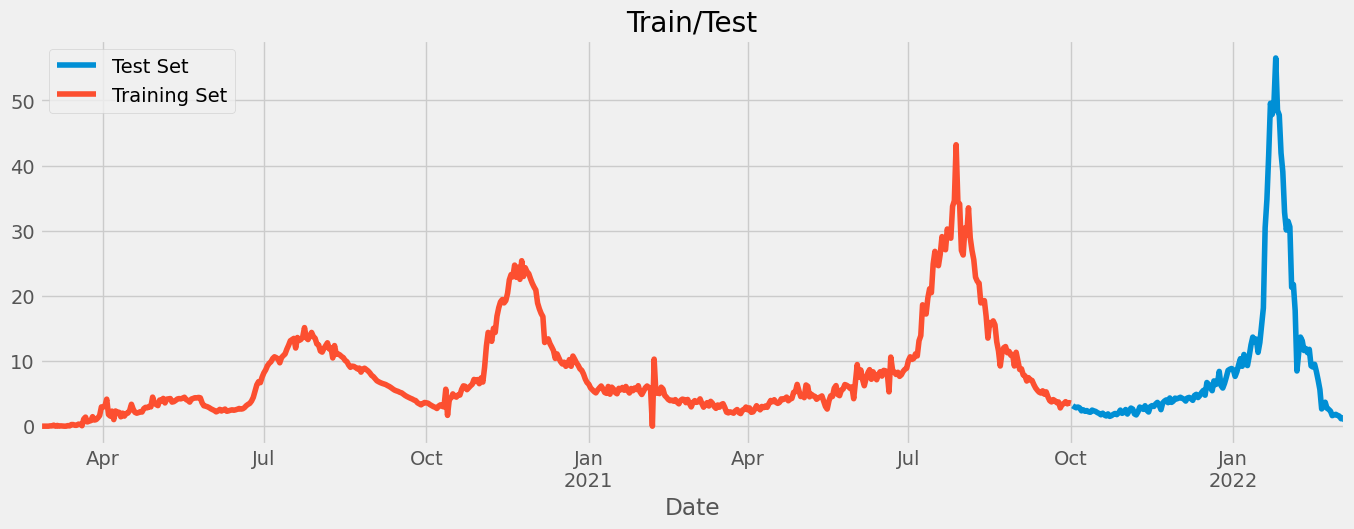

In [46]:
split_date='01-oct-2021'

africa_train2 = africa_2.loc[africa_2.index <=split_date].copy()
africa_test2 = africa_2.loc[africa_2.index >split_date].copy()

africa_test2 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(africa_train2.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [47]:
# Rename columns as required by Prophet
dataafrica_2 = africa_train2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [48]:
# Rename columns as required by Prophet
datetest_africa2 = africa_test2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [49]:
# Define function to evaluate model performance
def evaluate_model(predictions_africa2, actual_africa2):
    mse_africa2 = mean_squared_error(actual_africa2, predictions_africa2)
    rmse_africa2 = np.sqrt(mse_africa2)
    mape_africa2 = np.mean(np.abs((actual_africa2 - predictions_africa2) / actual_africa2)) * 100
    return mse_africa2, rmse_africa2, mape_africa2


In [50]:
# Initialize and fit the Prophet model on train data
model_africa2 = Prophet()
model_africa2.fit(dataafrica_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/wig8f5cs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/mc3om1zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50241', 'data', 'file=/tmp/tmpl3hu94pc/wig8f5cs.json', 'init=/tmp/tmpl3hu94pc/mc3om1zq.json', 'output', 'file=/tmp/tmpl3hu94pc/prophet_modelj6znt1g9/prophet_model-20230414154555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [51]:
n_days_africa2 = 365

In [52]:
future_dates_africa2 = model_africa2.make_future_dataframe(periods=n_days_africa2)

In [53]:
# Use the trained model to make predictions for the next n_days
forecast_africa2 = model_africa2.predict(future_dates_africa2)
# Access the 'yhat_lower' column
forecast_africa2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-02-25,1.226024,-7.048480,9.511418
1,2020-02-26,1.491213,-6.282337,8.655490
2,2020-02-27,1.401097,-6.111134,9.178666
3,2020-02-28,1.555532,-5.877166,9.026044
4,2020-02-29,1.071507,-6.890000,9.070418
...,...,...,...,...
945,2022-09-27,28.204048,17.962461,38.175471
946,2022-09-28,28.468854,18.544343,39.363646
947,2022-09-29,28.378354,17.987547,38.313130
948,2022-09-30,28.532406,18.180203,37.977044


In [54]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_africa2, forecast_africa2)
fig.show()

In [55]:
# Evaluate model performance on test data
test_predictions_africa2 = model_africa2.predict(datetest_africa2[['ds']])
test_predictions_africa2 = test_predictions_africa2[['ds', 'yhat']]
test_predictions_africa2 = test_predictions_africa2.merge(datetest_africa2, on='ds')
test_predictions_africa2 = test_predictions_africa2[['yhat', 'y']]
mse_africa2, rmse_africa2, mape_africa2 = evaluate_model(test_predictions_africa2['yhat'], test_predictions_africa2['y'])


In [56]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_africa2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_africa2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_africa2:.2f}%')

Mean Squared Error (MSE): 184.00
Root Mean Squared Error (RMSE): 13.56
Mean Absolute Percentage Error (MAPE): 358.33%


In [57]:
#NorthAmerica

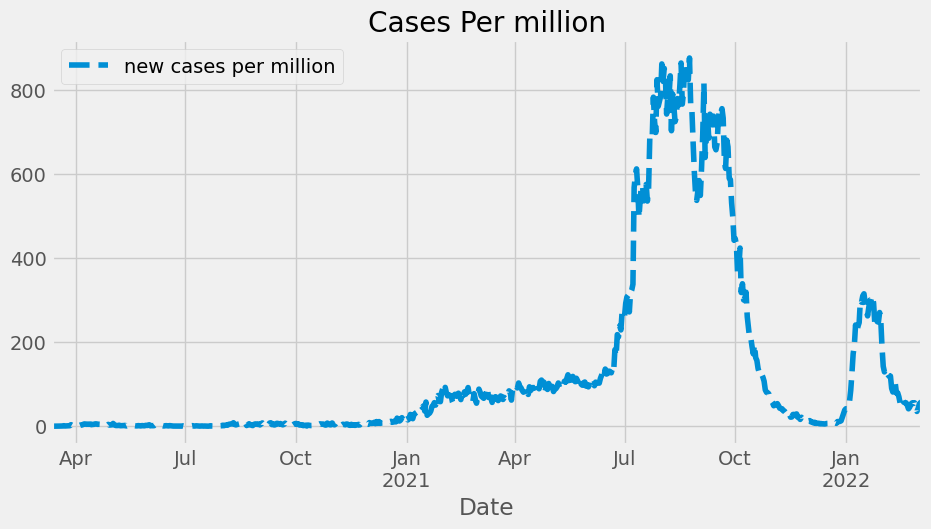

In [58]:
northamerica_1=create_df(data,'Cuba')

northamerica_1=northamerica_1.loc[:,['Date',"new cases per million"]]
northamerica_1=northamerica_1.set_index('Date')

color_pal = sns.color_palette()
northamerica_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

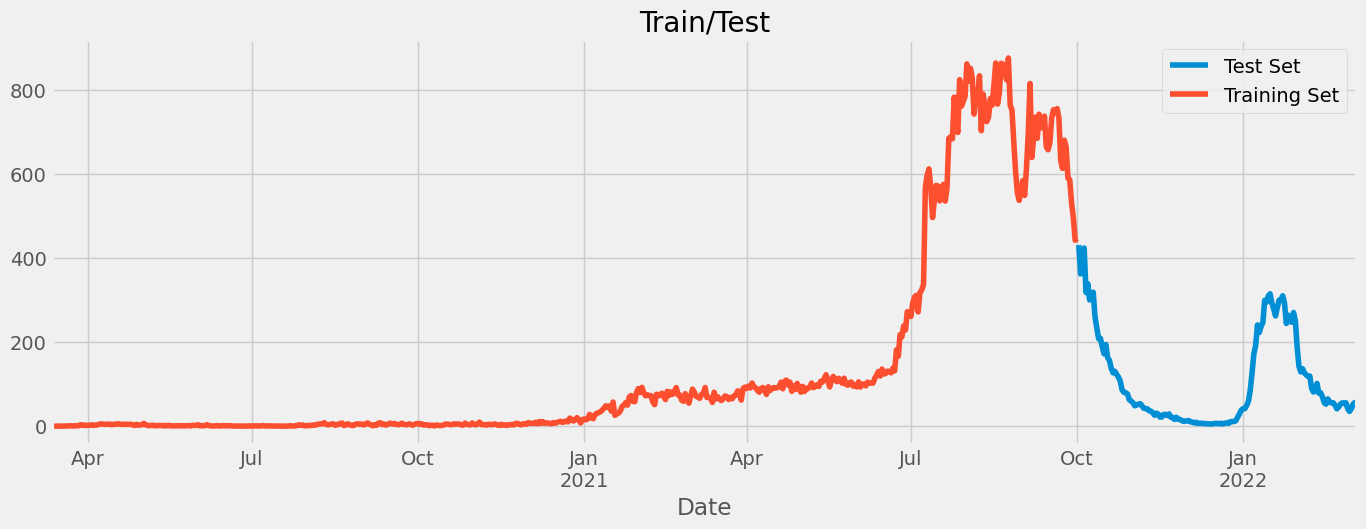

In [59]:
split_date='01-oct-2021'

northamerica_train1 = northamerica_1.loc[northamerica_1.index <=split_date].copy()
northamerica_test1 = northamerica_1.loc[northamerica_1.index >split_date].copy()

northamerica_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(northamerica_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [60]:
# Rename columns as required by Prophet
datanorthamerica_1 = northamerica_train1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})


In [61]:
# Rename columns as required by Prophet
datetest_northamerica1 = northamerica_test1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [62]:
# Define function to evaluate model performance
def evaluate_model(predictions_northamerica1, actual_northamerica1):
    mse_northamerica1 = mean_squared_error(actual_northamerica1, predictions_northamerica1)
    rmse_northamerica1 = np.sqrt(mse_northamerica1)
    mape_northamerica1 = np.mean(np.abs((actual_northamerica1 - predictions_northamerica1) / actual_northamerica1)) * 100
    return mse_northamerica1, rmse_northamerica1, mape_northamerica1


In [63]:
# Initialize and fit the Prophet model on train data
model_northamerica1 = Prophet()
model_northamerica1.fit(datanorthamerica_1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/vp37m865.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/2vtydadu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51865', 'data', 'file=/tmp/tmpl3hu94pc/vp37m865.json', 'init=/tmp/tmpl3hu94pc/2vtydadu.json', 'output', 'file=/tmp/tmpl3hu94pc/prophet_model2pz360o3/prophet_model-20230414154557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [64]:
n_days_northamerica1 = 365

In [65]:
future_dates_northamerica1 = model_northamerica1.make_future_dataframe(periods=n_days_northamerica1)

In [66]:
# Use the trained model to make predictions for the next n_days
forecast_northamerica1 = model_northamerica1.predict(future_dates_northamerica1)
# Access the 'yhat_lower' column
forecast_northamerica1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-12,-12.046090,-108.346753,83.876427
1,2020-03-13,-4.959057,-105.965167,101.231005
2,2020-03-14,-0.755266,-99.826168,97.077246
3,2020-03-15,1.273639,-105.928871,108.010238
4,2020-03-16,-7.272532,-115.015131,96.728759
...,...,...,...,...
929,2022-09-27,2741.870640,2433.668876,3059.100264
930,2022-09-28,2743.623881,2407.646031,3054.086968
931,2022-09-29,2745.730207,2424.587802,3054.775410
932,2022-09-30,2758.013518,2435.603624,3075.023854


In [67]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_northamerica1, forecast_northamerica1)
fig.show()

In [68]:
# Evaluate model performance on test data
test_predictions_northamerica1 = model_northamerica1.predict(datetest_northamerica1[['ds']])
test_predictions_northamerica1 = test_predictions_northamerica1[['ds', 'yhat']]
test_predictions_northamerica1 = test_predictions_northamerica1.merge(datetest_northamerica1, on='ds')
test_predictions_northamerica1 = test_predictions_northamerica1[['yhat', 'y']]
mse_northamerica1, rmse_northamerica1, mape_northamerica1 = evaluate_model(test_predictions_northamerica1['yhat'], test_predictions_northamerica1['y'])

In [69]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_northamerica1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_northamerica1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_northamerica1:.2f}%')

Mean Squared Error (MSE): 1385854.21
Root Mean Squared Error (RMSE): 1177.22
Mean Absolute Percentage Error (MAPE): 4735.34%


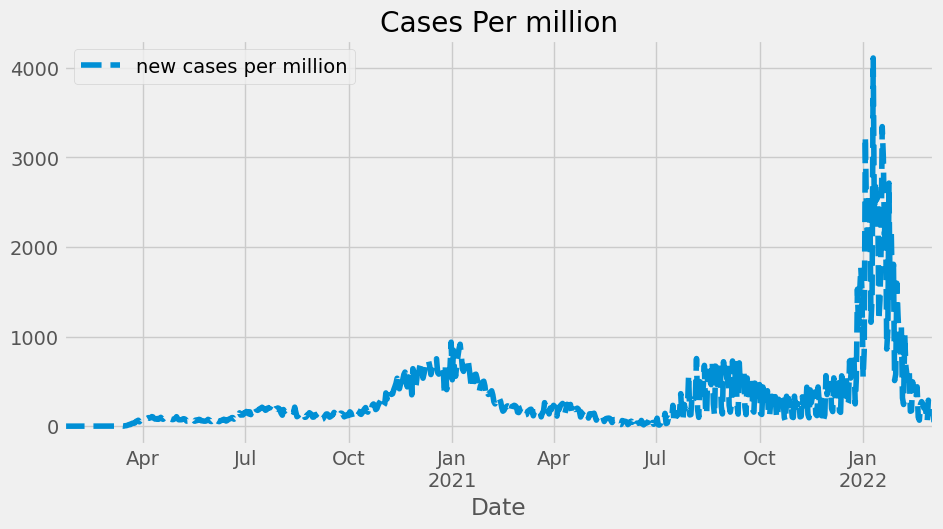

In [70]:
northamerica_2=create_df(data,"United States")

northamerica_2=northamerica_2.loc[:,['Date',"new cases per million"]]
northamerica_2=northamerica_2.set_index('Date')

color_pal = sns.color_palette()
northamerica_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()


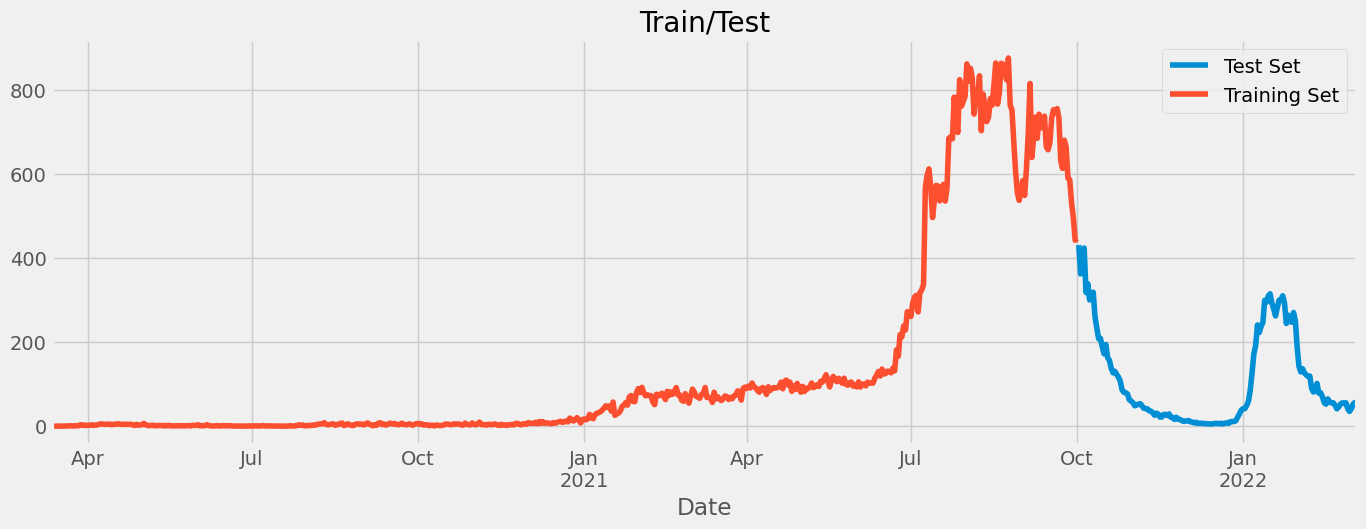

In [71]:
split_date='01-oct-2021'

northamerica_train2 = northamerica_2.loc[northamerica_2.index <=split_date].copy()
northamerica_test2 = northamerica_2.loc[northamerica_2.index >split_date].copy()

northamerica_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(northamerica_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()


In [72]:

# Rename columns as required by Prophet
datanorthamerica_2 = northamerica_train2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})


In [73]:
# Rename columns as required by Prophet
datetest_northamerica2 = northamerica_test2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [74]:
# Define function to evaluate model performance
def evaluate_model(predictions_northamerica2, actual_northamerica2):
    mse_northamerica2 = mean_squared_error(actual_northamerica2, predictions_northamerica2)
    rmse_northamerica2 = np.sqrt(mse_northamerica1)
    mape_northamerica2 = np.mean(np.abs((actual_northamerica2 - predictions_northamerica2) / actual_northamerica2)) * 100
    return mse_northamerica2, rmse_northamerica2, mape_northamerica2

In [75]:
# Initialize and fit the Prophet model on train data
model_northamerica2 = Prophet()
model_northamerica2.fit(datanorthamerica_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/yjcedr_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3hu94pc/fkverbyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1909', 'data', 'file=/tmp/tmpl3hu94pc/yjcedr_p.json', 'init=/tmp/tmpl3hu94pc/fkverbyr.json', 'output', 'file=/tmp/tmpl3hu94pc/prophet_modeli9kassvj/prophet_model-20230414154559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [76]:
n_days_northamerica2 = 365

In [77]:
future_dates_northamerica2 = model_northamerica2.make_future_dataframe(periods=n_days_northamerica2)

In [78]:
# Use the trained model to make predictions for the next n_days
forecast_northamerica2 = model_northamerica2.predict(future_dates_northamerica2)
# Access the 'yhat_lower' column
forecast_northamerica2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-8.792936,-147.640556,135.979048
1,2020-01-23,0.267404,-134.591656,131.874056
2,2020-01-24,34.109046,-106.320826,161.205324
3,2020-01-25,-34.698990,-164.759595,95.220168
4,2020-01-26,-76.868271,-208.016303,67.857634
...,...,...,...,...
979,2022-09-27,1405.610919,563.442838,2191.599679
980,2022-09-28,1421.111018,532.010896,2210.895558
981,2022-09-29,1432.032319,565.950449,2213.231772
982,2022-09-30,1467.734922,619.505488,2258.944191


In [79]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_northamerica2, forecast_northamerica2)
fig.show()

In [80]:
# Evaluate model performance on test data
test_predictions_northamerica2 = model_northamerica2.predict(datetest_northamerica2[['ds']])
test_predictions_northamerica2 = test_predictions_northamerica2[['ds', 'yhat']]
test_predictions_northamerica2 = test_predictions_northamerica2.merge(datetest_northamerica2, on='ds')
test_predictions_northamerica2 = test_predictions_northamerica2[['yhat', 'y']]
mse_northamerica2, rmse_northamerica2, mape_northamerica2 = evaluate_model(test_predictions_northamerica2['yhat'], test_predictions_northamerica2['y'])

In [81]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_northamerica2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_northamerica2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_northamerica2:.2f}%')

Mean Squared Error (MSE): 583197.93
Root Mean Squared Error (RMSE): 1177.22
Mean Absolute Percentage Error (MAPE): 157.82%


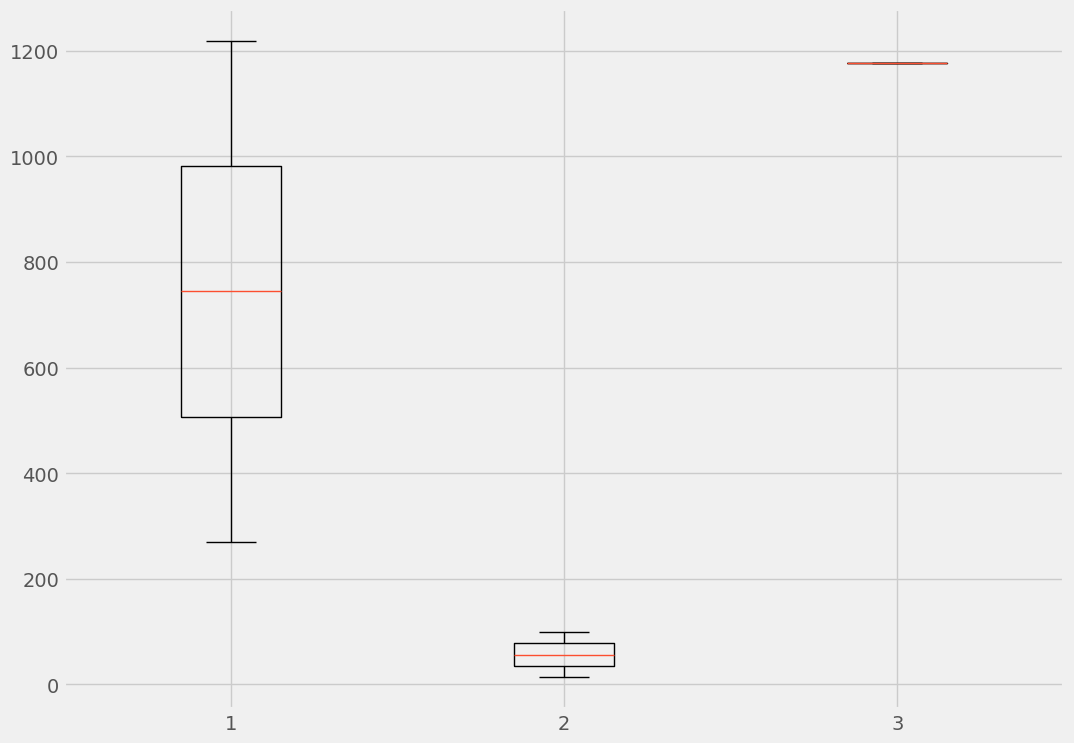

In [82]:
#RMSE

rmse_asia=(rmse_asia1,rmse_asia2)
rmse_africa=(rmse_africa1,rmse_africa2)
rmse_northamerica=(rmse_northamerica1,rmse_northamerica2)

rmse_all=[rmse_asia,rmse_africa,rmse_northamerica]


fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(rmse_all)
 
# show plot
plt.show()


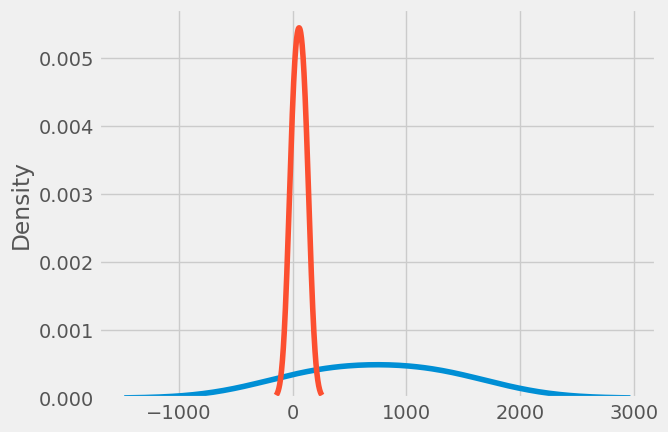

In [83]:
# Create a density distribution

sns.kdeplot(rmse_asia, label='RMSE 1')
sns.kdeplot(rmse_africa, label='RMSE 2')
sns.kdeplot(rmse_northamerica, label='RMSE 3')

# Show the plot
import matplotlib.pyplot as plt
plt.show()